In [51]:
import pandas as pd
import numpy as np
from tqdm import tqdm_notebook as tqdm
from torch.optim.optimizer import Optimizer
import matplotlib.pyplot as plt
from copy import deepcopy
import gc
gc.collect()

142

# MADGRAD

In [52]:
import math
from typing import TYPE_CHECKING, Any, Callable, Optional

if TYPE_CHECKING:
    from torch.optim.optimizer import _params_t
else:
    _params_t = Any

class MADGRAD(Optimizer):

    def __init__(
        self, params: _params_t, lr: float = 1e-2, momentum: float = 0.9, weight_decay: float = 0, eps: float = 1e-6,
    ):
        if momentum < 0 or momentum >= 1:
            raise ValueError(f"Momentum {momentum} must be in the range [0,1]")
        if lr <= 0:
            raise ValueError(f"Learning rate {lr} must be positive")
        if weight_decay < 0:
            raise ValueError(f"Weight decay {weight_decay} must be non-negative")
        if eps < 0:
            raise ValueError(f"Eps must be non-negative")

        defaults = dict(lr=lr, eps=eps, momentum=momentum, weight_decay=weight_decay)
        super().__init__(params, defaults)

    @property
    def supports_memory_efficient_fp16(self) -> bool:
        return False

    @property
    def supports_flat_params(self) -> bool:
        return True

    def step(self, closure: Optional[Callable[[], float]] = None) -> Optional[float]:

        loss = None
        if closure is not None:
            loss = closure()

        if 'k' not in self.state:
            self.state['k'] = torch.tensor([0], dtype=torch.long)
        k = self.state['k'].item()

        for group in self.param_groups:
            eps = group["eps"]
            lr = group["lr"] + eps
            decay = group["weight_decay"]
            momentum = group["momentum"]

            ck = 1 - momentum
            lamb = lr * math.pow(k + 1, 0.5)

            for p in group["params"]:
                if p.grad is None:
                    continue
                grad = p.grad.data
                state = self.state[p]

                if "grad_sum_sq" not in state:
                    state["grad_sum_sq"] = torch.zeros_like(p.data).detach()
                    state["s"] = torch.zeros_like(p.data).detach()
                    if momentum != 0:
                        state["x0"] = torch.clone(p.data).detach()

                if momentum != 0.0 and grad.is_sparse:
                    raise RuntimeError("momentum != 0 is not compatible with sparse gradients")

                grad_sum_sq = state["grad_sum_sq"]
                s = state["s"]

                # Apply weight decay
                if decay != 0:
                    if grad.is_sparse:
                        raise RuntimeError("weight_decay option is not compatible with sparse gradients")

                    grad.add_(p.data, alpha=decay)

                if grad.is_sparse:
                    grad = grad.coalesce()
                    grad_val = grad._values()

                    p_masked = p.sparse_mask(grad)
                    grad_sum_sq_masked = grad_sum_sq.sparse_mask(grad)
                    s_masked = s.sparse_mask(grad)

                    # Compute x_0 from other known quantities
                    rms_masked_vals = grad_sum_sq_masked._values().pow(1 / 3).add_(eps)
                    x0_masked_vals = p_masked._values().addcdiv(s_masked._values(), rms_masked_vals, value=1)

                    # Dense + sparse op
                    grad_sq = grad * grad
                    grad_sum_sq.add_(grad_sq, alpha=lamb)
                    grad_sum_sq_masked.add_(grad_sq, alpha=lamb)

                    rms_masked_vals = grad_sum_sq_masked._values().pow_(1 / 3).add_(eps)

                    s.add_(grad, alpha=lamb)
                    s_masked._values().add_(grad_val, alpha=lamb)

                    # update masked copy of p
                    p_kp1_masked_vals = x0_masked_vals.addcdiv(s_masked._values(), rms_masked_vals, value=-1)
                    # Copy updated masked p to dense p using an add operation
                    p_masked._values().add_(p_kp1_masked_vals, alpha=-1)
                    p.data.add_(p_masked, alpha=-1)
                else:
                    if momentum == 0:
                        # Compute x_0 from other known quantities
                        rms = grad_sum_sq.pow(1 / 3).add_(eps)
                        x0 = p.data.addcdiv(s, rms, value=1)
                    else:
                        x0 = state["x0"]

                    # Accumulate second moments
                    grad_sum_sq.addcmul_(grad, grad, value=lamb)
                    rms = grad_sum_sq.pow(1 / 3).add_(eps)

                    # Update s
                    s.data.add_(grad, alpha=lamb)

                    # Step
                    if momentum == 0:
                        p.data.copy_(x0.addcdiv(s, rms, value=-1))
                    else:
                        z = x0.addcdiv(s, rms, value=-1)

                        # p is a moving average of z
                        p.data.mul_(1 - ck).add_(z, alpha=ck)


        self.state['k'] += 1
        return loss

# LOAD DATA

In [53]:
train_df = pd.read_csv('Train_Product_Data_2021_0114.csv',index_col=0).drop(['Forward','Backward'],axis=1)
print(train_df.shape)
train_df = train_df.dropna(axis=0)
print(train_df.shape)
train_df.head(3)

(1732, 6)
(1732, 6)


,string_X_train,string_Y_1,string_Y_2,Y_label,row_id,label_for_train
586,"YUNGSOX 2100M 12MT USD1,015/MT USD12,180 YUNGS...",0,13,YUNGSOX 2100M,855,"{'Product':[( 0 , 13 )]}"
92,"TRIS 1,2-CYCLOHEXANE DICARBOXYLIC ACID,DI-ISON...",0,50,"TRIS 1,2-CYCLOHEXANE DICARBOXYLIC ACID,DI-ISON...",140,"{'Product':[( 0 , 50 )]}"
91,"TRIS . CIF PORT KLANG,MALAYSIA",0,4,TRIS,139,"{'Product':[( 0 , 4 )]}"


In [54]:
val_df = pd.read_csv('Val_Product_Data_2021_0114.csv',index_col=0).drop(['Forward','Backward'],axis=1)
print(val_df.shape)
val_df = val_df.dropna(axis=0)
print(val_df.shape)
val_df.head(3)

(744, 5)
(744, 5)


,string_X_train,string_Y_1,string_Y_2,Y_label,row_id
1,"COMMODITY: STYRENE MONOMER IN BULKQUANTITY: 3,...",11,34,STYRENE MONOMER IN BULK,1
2,"COMMODITY: STYRENE MONOMER IN BULKQUANTITY: 3,...",11,34,STYRENE MONOMER IN BULK,2
3,PP 3307UNC1 . TRADE TERMS: CFR ANY JAPANESE PORT,0,2,PP,10


# Model and Tokenizer Initialization

In [55]:
from transformers import DistilBertTokenizerFast
from transformers import DistilBertForQuestionAnswering

tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')
model = DistilBertForQuestionAnswering.from_pretrained("distilbert-base-uncased")
gc.collect()

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForQuestionAnswering: ['vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_projector.weight']
- This IS expected if you are initializing DistilBertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForQuestionAnswering were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this mode

223

# Data preprocessing

In [56]:
def preprocessing(df):
    contexts = df['string_X_train'].values.tolist()
    questions = [ 'What is the product name?' for i in range(len(df))]
    answers = []
    for idx in df.index:
        answers.append({
            'text':df.loc[idx,'Y_label'],
            'answer_start':df.loc[idx,'string_Y_1'],
            'answer_end':df.loc[idx,'string_Y_2'],
            })
    return contexts ,questions ,answers

train_contexts ,train_questions ,train_answers = preprocessing(train_df)
val_contexts ,val_questions ,val_answers = preprocessing(val_df)
gc.collect()

0

# tokenize our context/question pairs

In [57]:
train_encodings = tokenizer(train_contexts, train_questions, truncation=True, padding=True)
val_encodings = tokenizer(val_contexts, val_questions, truncation=True, padding=True)
gc.collect()

0

# add_token_positions

In [58]:
def add_token_positions(encodings, answers):
    start_positions = []
    end_positions = []
    for i in range(len(answers)):
        start_positions.append(encodings.char_to_token(i, answers[i]['answer_start']))
        end_positions.append(encodings.char_to_token(i, answers[i]['answer_end'] - 1))

        # if start position is None, the answer passage has been truncated
        if start_positions[-1] is None:
            start_positions[-1] = tokenizer.model_max_length
        if end_positions[-1] is None:
            end_positions[-1] = tokenizer.model_max_length

    encodings.update({'start_positions': start_positions, 'end_positions': end_positions})

add_token_positions(train_encodings, train_answers)
add_token_positions(val_encodings, val_answers)
gc.collect()

20

# data is ready put it in a PyTorch dataset

In [59]:
import torch

class SquadDataset(torch.utils.data.Dataset):
    def __init__(self, encodings):
        self.encodings = encodings

    def __getitem__(self, idx):
        return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}

    def __len__(self):
        return len(self.encodings.input_ids)

train_dataset = SquadDataset(train_encodings)
val_dataset = SquadDataset(val_encodings)
gc.collect()

20

# train loop

In [60]:
from torch.utils.data import DataLoader
from torch.optim import Adam

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)
model.to(device)
model.train()
train_loader = DataLoader(train_dataset, batch_size = 64, shuffle=True ,num_workers=4)
val_loader = DataLoader(val_dataset, batch_size = 64, shuffle=True ,num_workers=4)
optim = MADGRAD(model.parameters(),lr=5e-5)
gc.collect()

def train_step(batch):
    # forward
    input_ids = batch['input_ids'].to(device)
    attention_mask = batch['attention_mask'].to(device)
    start_positions = batch['start_positions'].to(device)
    end_positions = batch['end_positions'].to(device)
    outputs = model(input_ids, attention_mask=attention_mask, start_positions=start_positions, end_positions=end_positions)
    loss = outputs[0]
    
    # update model
    loss.backward()
    optim.step()
    optim.zero_grad()
    
    gc.collect()
    return loss.item()

def val_step(batch):
    # forward
    input_ids = batch['input_ids'].to(device)
    attention_mask = batch['attention_mask'].to(device)
    start_positions = batch['start_positions'].to(device)
    end_positions = batch['end_positions'].to(device)
    outputs = model(input_ids, attention_mask=attention_mask, start_positions=start_positions, end_positions=end_positions)
    loss = outputs[0]
    
    gc.collect()
    return loss.item()

k = 10
history = {'train_loss':[],
           'val_loss':[]}
best_loss = np.inf
best_model = None
not_improve_count = 0
patience = 3

for epoch in tqdm(range(k)):    
    
    # reset this epoch loss equal to zero
    epoch_train_loss = 0.0
    epoch_val_loss = 0.0
    
    # train one epoch and get train_loss
    for i,batch in enumerate(tqdm(train_loader)):
        epoch_train_loss += train_step(batch)
    
    # val one epoch and get val_loss
    for j,batch in enumerate(tqdm(val_loader)):
        epoch_val_loss += val_step(batch)
    
    # record loss history
    history['train_loss'].append(epoch_train_loss/i)
    history['val_loss'].append(epoch_val_loss/j)
    
    # print this epoch's infomation
    print(f'epoch:{epoch} train_loss:{epoch_train_loss} val_loss:{epoch_val_loss}')
    
    # save best_model (if current val_loss <= best_loss)
    if history['val_loss'][-1] <= best_loss: 
        best_model = deepcopy(model.eval())
        best_loss = history['val_loss'][-1]
        print(f'save best_model now_val_best_loss is:{best_loss}')
    
    if history['val_loss'][-1] > best_loss:
        not_improve_count += 1
        if not_improve_count >= patience:
            break
            
# GET best_model.eval()
model = best_model.eval()

cuda


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:50: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/10 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:57: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/28 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:61: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/12 [00:00<?, ?it/s]

epoch:0 train_loss:75.66995194554329 val_loss:5.518517047166824
save best_model now_val_best_loss is:0.5016833679242567


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

epoch:1 train_loss:13.38434587419033 val_loss:3.2643196433782578
save best_model now_val_best_loss is:0.29675633121620526


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

epoch:2 train_loss:7.629917562007904 val_loss:3.0533803030848503
save best_model now_val_best_loss is:0.2775800275531682


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

epoch:3 train_loss:6.455754242837429 val_loss:3.393228456377983


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

epoch:4 train_loss:5.310405991971493 val_loss:2.864381417632103
save best_model now_val_best_loss is:0.2603983106938275


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

epoch:5 train_loss:4.493959002196789 val_loss:3.471189007163048


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

epoch:6 train_loss:3.626721028704196 val_loss:3.2558497339487076


# loss curve

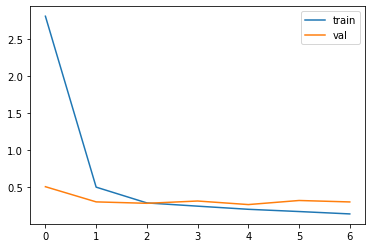

In [61]:
plt.plot(history['train_loss'],label='train')
plt.plot(history['val_loss'],label='val')
plt.legend()
plt.show()

# test

In [62]:
from transformers import pipeline
nlp = pipeline('question-answering', model=model.to('cpu'), tokenizer=tokenizer)

In [63]:
def test_model(df,n_test):
    i = 0
    table = pd.DataFrame()
    for _ in tqdm(range(n_test)):
        sample = df.sample(1)
        string_X_train = sample['string_X_train'].values[0]
        string_Y_1 = sample['string_Y_1'].values[0]
        string_Y_2 = sample['string_Y_2'].values[0]
        QA_input = {
            'question': 'What is the product name?',
            'context': string_X_train
        }
        res = nlp(QA_input)
        predict = QA_input['context'][res['start']:res['end']]
        row = pd.DataFrame({
            'label':string_X_train[string_Y_1:string_Y_2],
            'predict:':predict},index=[i])
        if string_X_train[string_Y_1:string_Y_2] == predict:
            row['是否全對'] = 'Yes'
        else:
            row['是否全對'] = 'No'
        table = table.append(row)
        i += 1
    display(table)
    return table

# 最後讓我們來看看模型在驗證集上的表現

In [64]:
test_model(val_df,50)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


  0%|          | 0/50 [00:00<?, ?it/s]

,label,predict:,是否全對
0,N-BUTANOL,N-BUTANOL,Yes
1,EVA TAISOX,EVA TAISOX,Yes
2,PP,PP,Yes
3,ABS,ABS,Yes
4,ETHYLENE-PROPYLENE COPOLYMERS PP COPOLYMER YUN...,ETHYLENE-PROPYLENE COPOLYMERS,No
5,METHYL METHACRYLATE,METHYL METHACRYLATE + INHIBITOR,No
6,ETHYL ACRYLATE,ETHYL ACRYLATE,Yes
7,ETHYLENE-PROPYLENE COPOLYMERS PP COPOLYMER YUN...,ETHYLENE-PROPYLENE COPOLYMERS,No
8,POLYETHYLENE TEREPHTHALATE FILM,POLYESTER FILM,No
9,PET RESIN,PET RESIN,Yes


,label,predict:,是否全對
0,N-BUTANOL,N-BUTANOL,Yes
1,EVA TAISOX,EVA TAISOX,Yes
2,PP,PP,Yes
3,ABS,ABS,Yes
4,ETHYLENE-PROPYLENE COPOLYMERS PP COPOLYMER YUN...,ETHYLENE-PROPYLENE COPOLYMERS,No
5,METHYL METHACRYLATE,METHYL METHACRYLATE + INHIBITOR,No
6,ETHYL ACRYLATE,ETHYL ACRYLATE,Yes
7,ETHYLENE-PROPYLENE COPOLYMERS PP COPOLYMER YUN...,ETHYLENE-PROPYLENE COPOLYMERS,No
8,POLYETHYLENE TEREPHTHALATE FILM,POLYESTER FILM,No
9,PET RESIN,PET RESIN,Yes


# claculate acc and jaccard

In [65]:
all_res = test_model(val_df,len(val_df))

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


  0%|          | 0/744 [00:00<?, ?it/s]

,label,predict:,是否全對
0,ETHYL ACRYLATE,ETHYL ACRYLATE,Yes
1,PROPYLENE COPOLYMER,PROPYLENE COPOLYMER,Yes
2,METHYL METHACRYLATE,METHYL METHACRYLATE,Yes
3,TAIRILIN BRAND POLYESTER FILM B,TAIRILIN BRAND POLYESTER FILM B,Yes
4,MONO ETHYLENE GLYCOL MEG,MONO ETHYLENE GLYCOL,No
...,...,...,...
739,POLYCARBONATE RESIN,POLYCARBONATE RESIN,Yes
740,MONO ETHYLENE GLYCOL,MONO ETHYLENE GLYCOL,Yes
741,GPPS GP5250,GPPS GP5250,Yes
742,ABS AG15A1-H,ABS AG15A1-H,Yes


In [66]:
all_res['是否全對'].value_counts()

Yes    610
No     134
Name: 是否全對, dtype: int64

In [67]:
acc = all_res['是否全對'].value_counts()['Yes']/len(val_df)
acc

0.8198924731182796

# jaccard

In [68]:
def get_jaccard_sim(str1, str2): 
    a = set(str1.split()) 
    b = set(str2.split())
    c = a.intersection(b)
    return float(len(c)) / (len(a) + len(b) - len(c))

In [69]:
jaccard_avg_score = np.mean([ get_jaccard_sim(all_res.label[i],all_res['predict:'][i]) for i in range(len(all_res))])
jaccard_avg_score 

0.9052195340501792